In [ ]:
import os
from collections import Counter
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

In [42]:
# Define base directory
base_dir = '../data/chest_xray'

In [46]:
# Function to count images by type (normal, virus, bacteria)
def count_images_by_type(base_path):
    counts = Counter()
    for dataset_type in ['train', 'test', 'val']:
        dataset_path = os.path.join(base_path, dataset_type)
        for label in ['NORMAL', 'PNEUMONIA']:
            label_path = os.path.join(dataset_path, label)
            if label == "NORMAL":
                # Count all images in the NORMAL folder as "normal"
                counts[(dataset_type, "normal")] = len(os.listdir(label_path))
            elif label == "PNEUMONIA":
                for image_name in os.listdir(label_path):
                    if "virus" in image_name.lower():
                        counts[(dataset_type, "virus")] += 1
                    elif "bacteria" in image_name.lower():
                        counts[(dataset_type, "bacteria")] += 1
    return counts


# Count images
image_counts = count_images_by_type(base_dir)

# Create a DataFrame for better visualization
df = pd.DataFrame.from_dict(image_counts, orient='index', columns=['Image Count'])
df.index = pd.MultiIndex.from_tuples(df.index, names=["Set", "Type"])

# Display the table
df.head(11)


Image Count
Set   Type                 
train normal           1341
      bacteria         2530
      virus            1345
test  normal            234
      bacteria          242
      virus             148
val   normal              8
      bacteria            8

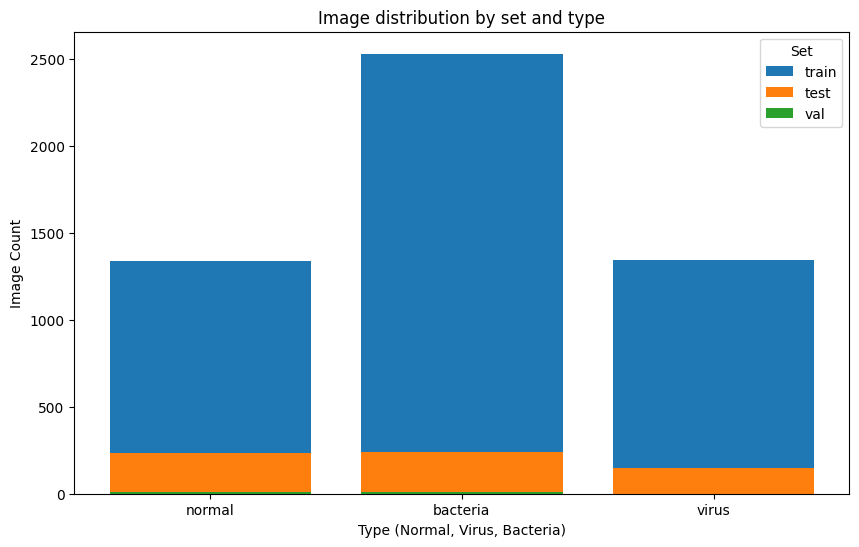

In [47]:
# Reset index for plotting
df_reset = df.reset_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
for dataset_type in ['train', 'test', 'val']:
    subset = df_reset[df_reset['Set'] == dataset_type]
    plt.bar(subset['Type'], subset['Image Count'], label=dataset_type)

plt.title('Image distribution by set and type')
plt.xlabel('Type (Normal, Virus, Bacteria)')
plt.ylabel('Image Count')
plt.legend(title='Set')
plt.show()

In [48]:
# Calculate percentage of each type within each set
df_percentage = df.groupby(level=0).apply(lambda x: 100 * x / x.sum())
print("Percentage distribution within each set:")
print(df_percentage)

Percentage distribution within each set:
                      Image Count
Set   Set   Type                 
test  test  normal      37.500000
            bacteria    38.782051
            virus       23.717949
train train normal      25.709356
            bacteria    48.504601
            virus       25.786043
val   val   normal      50.000000
            bacteria    50.000000


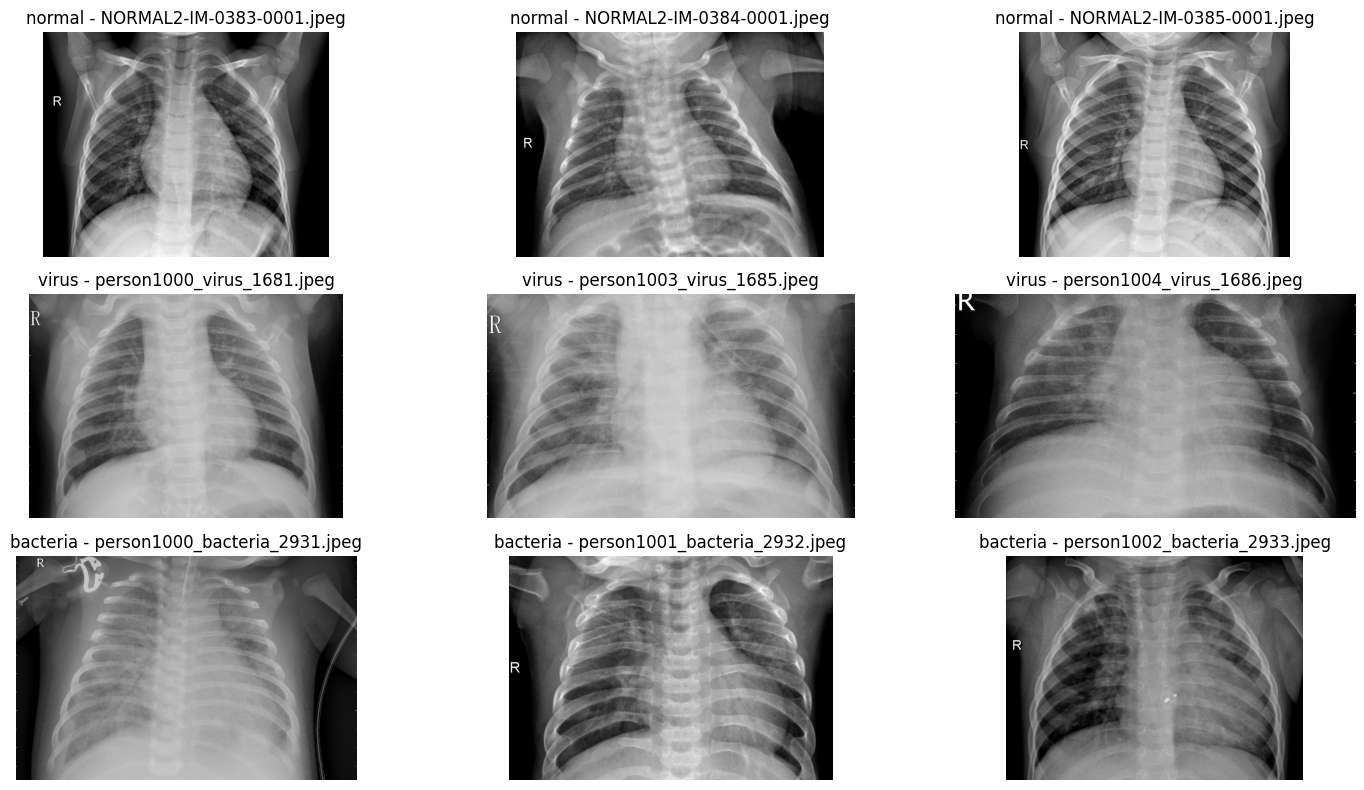

In [ ]:
def display_sample_images(base_path, num_samples=3):
    categories = [('NORMAL', 'normal'), ('PNEUMONIA', 'virus'), ('PNEUMONIA', 'bacteria')]
    fig, axes = plt.subplots(len(categories), num_samples, figsize=(15, 8))

    for i, (folder, label) in enumerate(categories):
        folder_path = os.path.join(base_path, 'train', folder)
        sample_images = [img for img in os.listdir(folder_path) if label in img.lower()][:num_samples]
        
        for j, img_name in enumerate(sample_images):
            img_path = os.path.join(folder_path, img_name)
            img = Image.open(img_path).convert('L')  # Convert image to grayscale
            axes[i, j].imshow(img, cmap='gray')  # Use grayscale colormap
            axes[i, j].axis('off')
            axes[i, j].set_title(f"{label} - {img_name}")
    
    plt.tight_layout()
    plt.show()

display_sample_images(base_dir)

Small files (less than 10 KB):
43


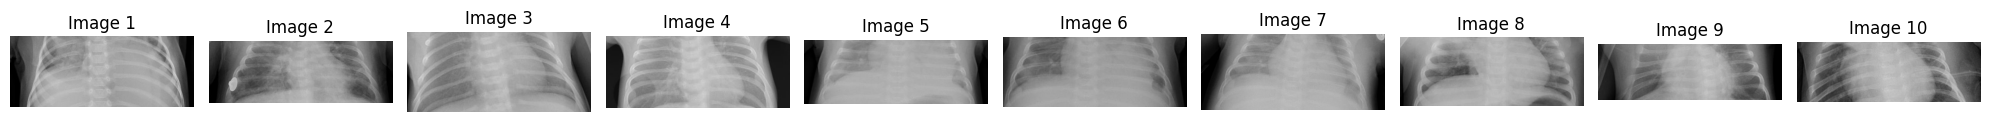

In [ ]:
# Check for images smaller than a certain size threshold (e.g., 10 KB)
small_files = []

# Define the base directory and check for small images
for dataset_type in ['train', 'test', 'val']:
    for label in ['NORMAL', 'PNEUMONIA']:
        folder_path = os.path.join(base_dir, dataset_type, label)
        for image_name in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_name)
            if os.path.getsize(image_path) < 10 * 1024:  # 10 KB
                small_files.append(image_path)

print("Small files (less than 10 KB):")
print(len(small_files)) 

# Display the first 10 small images
num_samples = min(10, len(small_files))  # Ensure we don't exceed available small images
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i, image_path in enumerate(small_files[:num_samples]):
    img = Image.open(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [57]:
def check_grayscale_images(image_paths):
    grayscale_count = 0
    color_count = 0

    for image_path in image_paths:
        img = Image.open(image_path)
        if img.mode == 'L':  # 'L' mode means grayscale
            grayscale_count += 1
        else:
            color_count += 1

    print(f"Grayscale images: {grayscale_count}")
    print(f"Color images: {color_count}")

# Check grayscale status for small files
check_grayscale_images(small_files[:43])


Grayscale images: 0
Color images: 43


In [ ]:
# Define thresholds for anomalous images
LOW_BRIGHTNESS_THRESHOLD = 50
HIGH_BRIGHTNESS_THRESHOLD = 200

# Initialize counters and lists
grayscale_count = 0
color_count = 0
brightness_values = []
anomalous_images = []

# Function to process images and collect statistics
def process_images(base_path):
    global grayscale_count, color_count

    for dataset_type in ['train', 'test', 'val']:
        for label in ['NORMAL', 'PNEUMONIA']:
            folder_path = os.path.join(base_path, dataset_type, label)
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                img = Image.open(image_path)

                # Check if image is grayscale
                if img.mode == 'L':
                    grayscale_count += 1
                else:
                    color_count += 1

                # Convert to grayscale for brightness analysis
                img = img.convert('L')
                img_array = np.array(img)

                # Compute average brightness
                avg_brightness = np.mean(img_array)
                brightness_values.append(avg_brightness)

                # Flag anomalous images
                if avg_brightness < LOW_BRIGHTNESS_THRESHOLD or avg_brightness > HIGH_BRIGHTNESS_THRESHOLD:
                    anomalous_images.append((image_path, avg_brightness))

# Define base directory
base_dir = '../data/chest_xray' 

# Process images
process_images(base_dir)

# Compute mean and standard deviation of pixel intensities
mean_pixel_intensity = np.mean(brightness_values)
std_pixel_intensity = np.std(brightness_values)

# Display results
print(f"Total images processed: {len(brightness_values)}")
print(f"Grayscale images: {grayscale_count}")
print(f"Color images: {color_count}")
print(f"Mean pixel intensity: {mean_pixel_intensity:.2f}")
print(f"Standard deviation of pixel intensity: {std_pixel_intensity:.2f}")
print(f"Number of anomalous images (brightness < {LOW_BRIGHTNESS_THRESHOLD} or > {HIGH_BRIGHTNESS_THRESHOLD}): {len(anomalous_images)}")

# Display the anomalous images
print("\nAnomalous images:")
for img_path, brightness in anomalous_images:
    print(f"{img_path}: Brightness = {brightness:.2f}")


Total images processed: 5856
Grayscale images: 5573
Color images: 283
Mean pixel intensity: 122.79
Standard deviation of pixel intensity: 18.39
Number of anomalous images (brightness < 50 or > 200): 2

Anomalous images:
../data/chest_xray\train\PNEUMONIA\person1405_bacteria_3564.jpeg: Brightness = 201.84
../data/chest_xray\train\PNEUMONIA\person1413_bacteria_3615.jpeg: Brightness = 221.54


Bright image vs "normal"


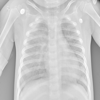

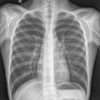

In [ ]:
# Paths to the images
image_bright = "../data/chest_xray/train/PNEUMONIA/person1405_bacteria_3564.jpeg"
image_normal = "../data/chest_xray/test/NORMAL/IM-0007-0001.jpeg"

# Desired display size (width, height)
display_size = (100, 100)  # Adjust as needed

print('Bright image vs "normal"')
img = Image.open(image_bright).resize(display_size)  # Resize the image
display(img)

img = Image.open(image_normal).resize(display_size)  # Resize the image
display(img)


In [ ]:
# Initialize lists to store statistics
image_stats = []
corrupted_images = []

# Function to process images and collect statistics
def process_images(base_path):
    for dataset_type in ['train', 'test', 'val']:
        for label in ['NORMAL', 'PNEUMONIA']:
            folder_path = os.path.join(base_path, dataset_type, label)
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                try:
                    # Open image and convert to grayscale
                    img = Image.open(image_path).convert('L')
                    img_array = np.array(img)

                    # Collect statistics: width, height, mean, std
                    width, height = img.size
                    mean_intensity = np.mean(img_array)
                    std_intensity = np.std(img_array)
                    image_stats.append((dataset_type, label, image_name, width, height, mean_intensity, std_intensity))

                except Exception as e:
                    # Flag corrupted images
                    corrupted_images.append(image_path)

# Define the base directory
base_dir = '../data/chest_xray'

# Process the images
process_images(base_dir)

# Create a DataFrame for the image statistics
df_stats = pd.DataFrame(image_stats, columns=['Set', 'Label', 'Image Name', 'Width', 'Height', 'Mean Intensity', 'Std Intensity'])

# Display basic statistics
print("Summary Statistics for Image Dimensions and Intensities:")
print(df_stats.describe())

# Display the list of corrupted images (if any)
if corrupted_images:
    print("\nCorrupted Images:")
    for img_path in corrupted_images:
        print(img_path)
else:
    print("\nNo corrupted images found.")

Summary Statistics for Image Dimensions and Intensities:
             Width       Height  Mean Intensity  Std Intensity
count  5856.000000  5856.000000     5856.000000    5856.000000
mean   1327.880806   970.689037      122.786271      56.989903
std     363.500922   383.392117       18.391648       9.396742
min     384.000000   127.000000       58.722966      20.415354
25%    1056.000000   688.000000      111.616378      50.736895
50%    1281.000000   888.000000      122.753346      57.328348
75%    1560.000000  1187.000000      134.313617      63.696503
max    2916.000000  2713.000000      221.536623      87.480423

No corrupted images found.
